Some really important papers and sites that assisted us.


**Credit must be given where it is due !**


*   https://lilianweng.github.io/posts/2020-10-29-odqa/#open-book-qa-retriever-generator

*   https://dev.to/ksk0629/my-own-chatbot-by-fine-tuning-gpt-2-m0n

* https://omarito.me/building-a-seq2seq-conversational-chat-bot-using-tensorflow/

* https://suriyadeepan.github.io/2016-06-28-easy-seq2seq/

* https://towardsdatascience.com/generative-chatbots-using-the-seq2seq-model-d411c8738ab5

* https://github.com/Marsan-Ma-zz/tf_chatbot_seq2seq_antilm

* https://github.com/minimaxir/gpt-2-simple

* https://github.com/ksk0629/chatbot_with_gpt2

* https://github.com/Conchylicultor/DeepQA/blob/master/chatbot/model.py

* https://github.com/UraliRana/Chatbot/blob/master/chatbot(Luong%20attention)small%20dataset/Untitled%20show.ipynb

* https://www.kaggle.com/code/jonathanbesomi/question-answering-starter-pack

* https://www.kaggle.com/code/thedrcat/question-answering-tutorial

* https://docs.aitextgen.io/gpt-2-simple/

* https://colab.research.google.com/github/gradio-app/gradio/blob/main/demo/text_generation/run.ipynb#scrollTo=2.8891853944186117e%2B38

* https://colab.research.google.com/drive/1VLG8e7YSEwypxU-noRNhsv5dW4NfTGce




#Imports&Installs

In [ ]:
!pip install -q gpt-2-simple

  Preparing metadata (setup.py) ... done


In [ ]:
# Miscellaneous
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from datetime import datetime
from google.colab import files

# NLP
import re
import string

# For Modeling DL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional, Embedding, Concatenate, Layer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Model
import tensorflow_hub as hub
from tensorflow.python.keras import backend as K

# for GPT-2
import gpt_2_simple as gpt2

In [ ]:
!gdown "1x7oymReme0U8czQHuft_EKN-dWm-2le4"

Downloading...
From: https://drive.google.com/uc?id=1x7oymReme0U8czQHuft_EKN-dWm-2le4
To: /content/NLP_Data.csv
100% 5.72M/5.72M [00:00<00:00, 197MB/s]


In [ ]:
gpt2.download_gpt2(model_name="124M")

Fetching checkpoint: 1.05Mit [00:00, 310Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:01, 626kit/s]
Fetching hparams.json: 1.05Mit [00:00, 135Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [01:25, 5.80Mit/s]
Fetching model.ckpt.index: 1.05Mit [00:00, 526Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:01, 841kit/s]
Fetching vocab.bpe: 1.05Mit [00:01, 841kit/s]


#Loading Data

In [ ]:
df = pd.read_csv("/content/NLP_Data.csv", index_col=0)

In [ ]:
df.head()

,Question,Answer
0,How can I keep my cat off my keyboard?,\nPlace a box near your keyboard that is the r...
1,How can I keep my cat off my keyboard?,This happens because my cat likes to sit on my...
2,How can I keep my cat off my keyboard?,I remember this from /r/funny a while back - a...
3,How can I keep my cat off my keyboard?,Animals need boundaries. The only way to preve...
4,How can I keep my cat off my keyboard?,The floating judgement box should work - I gue...


In [ ]:
Qs = df['Question']
As = df['Answer']

In [ ]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(As, Qs,test_size=0.05, shuffle = True, random_state = 8)

# split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.2, shuffle = True, random_state = 8)

In [ ]:
startMark = '<start>'
endMark = '<end>'

In [ ]:
def cleanText(text):
    # strip whitespaces and lowercase
    text = text.strip(' ').lower()
    text = re.sub(r'[^A-Za-z]', ' ', text)
    text = text.lower().strip()
    text = " ".join([word for word in text.split(" ") if word])
    return startMark+" "+text+" "+endMark

In [ ]:
As[511]

"Take a sip of water and swish it around in your mouth in the same way you would a fluoride rinse. This will push out most particles.\nI've used -- although it may not be the best idea -- a bent paperclip. It works essentially the same as a toothpick, but is metal, so it can hurt your gums if you're not careful. Use the bathroom mirror if possible."

In [ ]:
cleanText(As[511])

'<start> take a sip of water and swish it around in your mouth in the same way you would a fluoride rinse this will push out most particles i ve used although it may not be the best idea a bent paperclip it works essentially the same as a toothpick but is metal so it can hurt your gums if you re not careful use the bathroom mirror if possible <end>'

#Trial-1
Seq2Seq Model Inspired By the following [medium](https://medium.com/geekculture/neural-machine-translation-using-seq2seq-model-with-attention-9faea357d70b) article about MT made with a custom attention layer.


Even though this is what we call the copy-pasta attempt, We learned some things from it nonetheless.

##Model Architecture

In [ ]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
# adding special tokens and cleaning the text
df.Answer = df.Answer.apply(lambda x: cleanText(str(x)))

# Convert into list of sentence we need list to pass in tokenizer
Qs = df.Question.to_list()
As = df.Answer.to_list()

# Tokenize senteces with simple fuction
def tokenize_sent(text):
  '''
  Take list on texts as input and
  returns its tokenizer and enocoded text
  '''
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)


# Tokenize question and answer sentences
Qs_tokenizer, Qs_encoded = tokenize_sent(text = Qs)
As_tokenizer, As_encoded = tokenize_sent(text = As)

# Question Word --> index dictionary
Qs_index_word = Qs_tokenizer.index_word

# Question Index --> word dictionary
Qs_word_index= As_tokenizer.word_index

# size of Question vocabulary for encoder input we add +1 for the zero padding
Qs_VOCAB_SIZE = len(Qs_tokenizer.word_counts)+1

# Answer Word --> index dict
As_word_index= As_tokenizer.word_index

# Answer Index --> word dict
As_index_word = As_tokenizer.index_word

# Answer vocab size for decoder output
As_VOCAB_SIZE=len(As_tokenizer.word_counts)+1

# Getting max length of Question and Answer sentences
max_Q_len = 0
for i in range(len(Qs_encoded)):
  max_Q_len= max(max_Q_len, len(Qs_encoded[i]))

max_A_len = 0
for i in range(len(As_encoded)):
  max_A_len= max(max_A_len, len(As_encoded[i]))

# Padding both
Qs_padded = pad_sequences(Qs_encoded, maxlen=max_Q_len, padding='post')
As_padded = pad_sequences(As_encoded, maxlen=max_A_len, padding='post')

# Convert to array
Qs_padded= np.array(Qs_padded)
As_padded= np.array(As_padded)

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(Qs_padded, As_padded, test_size=0.01, shuffle = True, random_state = 8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = True, random_state = 8)

In [ ]:
encoder_inputs = Input(shape=(max_Q_len,))

# Embedding layer
enc_emb = Embedding(Qs_VOCAB_SIZE, 128)(encoder_inputs)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(128,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

# Concatenate both h and c
final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

# get Context vector
encoder_states =[final_enc_h, final_enc_c]

In [ ]:
# decoder input
decoder_inputs = Input(shape=(None,))

# decoder embedding with same number as encoder embedding
dec_emb_layer = Embedding(As_VOCAB_SIZE, 128)
dec_emb = dec_emb_layer(decoder_inputs)   # apply this way because we need embedding layer for prediction

# In encoder we used Bidirectional so it's having two LSTM's so we have to take double units(256*2=512) for single decoder lstm
# LSTM using encoder's final states as initial state
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Using Attention Layer
attention_layer = AttentionLayer()
attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

# Dense layer with softmax
decoder_dense = Dense(As_VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
base_learning_rate = 0.0009
Opt = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate)
checkpoint = ModelCheckpoint(
    monitor="val_loss",
    filepath="Final_Ws.h5",
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]
model.compile(optimizer=Opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

##Training

In [ ]:
# Training set
encoder_input_data = X_train
# Do the same to target data skip padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead
decoder_target_data =  y_train[:,1:]

# devlopment set
encoder_input_test = X_val
decoder_input_test = y_val[:,:-1]
decoder_target_test=  y_val[:,1:]

history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data,
                    epochs = 10,
                    batch_size = 16,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks = callbacks_list)

Epoch 1/10
529/529 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.9294
Epoch 1: val_loss improved from inf to 0.46115, saving model to Final_Ws.h5
529/529 [==============================] - 1708s 3s/step - loss: 0.5797 - accuracy: 0.9294 - val_loss: 0.4612 - val_accuracy: 0.9335
Epoch 2/10
529/529 [==============================] - ETA: 0s - loss: 0.4329 - accuracy: 0.9360
Epoch 2: val_loss improved from 0.46115 to 0.43088, saving model to Final_Ws.h5
529/529 [==============================] - 1675s 3s/step - loss: 0.4329 - accuracy: 0.9360 - val_loss: 0.4309 - val_accuracy: 0.9359
Epoch 3/10
529/529 [==============================] - ETA: 0s - loss: 0.4122 - accuracy: 0.9376
Epoch 3: val_loss improved from 0.43088 to 0.41935, saving model to Final_Ws.h5
529/529 [==============================] - 1712s 3s/step - loss: 0.4122 - accuracy: 0.9376 - val_loss: 0.4194 - val_accuracy: 0.9368
Epoch 4/10
529/529 [==============================] - ETA: 0s - loss: 0.4001 

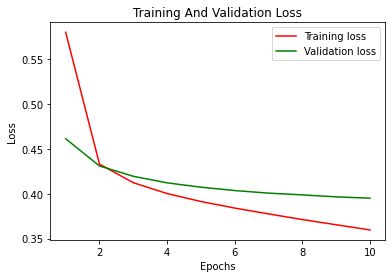

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training And Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

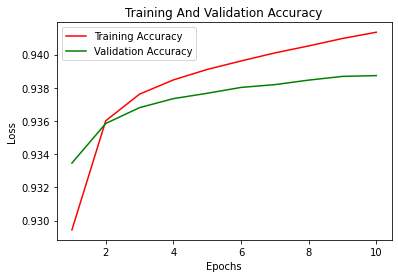

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc , 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training And Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Testing

In [ ]:
# Its good to restart runtime and create model and load weights
model.load_weights("Final_Ws.h5")

############################### INFERENCE MODEL ################################
# encoder Inference model
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

# Decoder Inference
decoder_state_h = Input(shape=(256,)) # This numbers has to be same as units of lstm's on which model is trained
decoder_state_c = Input(shape=(256,))

# we need hidden state for attention layer
# 28 is maximum length of a question sentence
decoder_hidden_state_input = Input(shape=(28,256))
# get decoder states
dec_states = [decoder_state_h, decoder_state_c]

# embedding layer
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

# get decoder model
decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = As_word_index['s']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c], verbose=0)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # convert max index number to marathi word
        sampled_char = As_index_word[sampled_token_index]
        # append it to decoded sent
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'e' or len(decoded_sentence.split()) >= 28):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        enc_h, enc_c = h, c

    return decoded_sentence

In [ ]:
# get the actual answer sentence
def get_A_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0 :
        sentence = sentence + As_index_word[i]+' '
    return sentence

# get the qeustion sentence
def get_Q_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence = sentence + Qs_index_word[i]+' '
    return sentence

# we will take 2 questions
for i in np.random.randint(0, 90, size=10):
  print("Question Sentence:",get_Q_sentence(X_test[i]))
  print("Actual Answer Sentence:",get_A_sentence(y_test[i]))
  # Before passing input it has to be reshape as following as the longest question was 28 tokens
  print("Predicted Answer Sentence:",get_predicted_sentence(X_test[i].reshape(1,28)))
  print("---"*50)

Question Sentence: how to steep but separate leaves in a teapot without a mesh strainer 
Actual Answer Sentence: s rather than using a strainer built into your teapot use an external strainer allow the hot water and loose tea leaves to hang out in your pot then pour through the strainer into your cup this one costs cdn on amazon ca i m sure you can find plenty in that price range slightly more expensive ones come with a little bowl to set them down in so as not to dribble on a counter e 
Predicted Answer Sentence:  i have a similar problem with a small amount of paper towel i ve had a few years ago and it s a little bit of a few
------------------------------------------------------------------------------------------------------------------------------------------------------
Question Sentence: randomizing papers 
Actual Answer Sentence: s take a well shuffled deck of cards and paperclip a card to each one in turn then sort them into deck order a k spades followed by a k hearts a k di

We Need to train MORE ! LIKE MORE MORE !

# Trial-2
# We will fine tune a GPT 2 Model

## Downloading GPT-2

Since we are retraining a model on new text, we need to download the GPT-2 model first.

There are three released sizes of GPT-2:

* `124M` (default): the "small" model, 500MB on disk.
* `355M`: the "medium" model, 1.5GB on disk.
* `774M`: the "large" model, cannot currently be finetuned with Colaboratory but can be used to generate text from the pretrained model (see later in Notebook)
* `1558M`: the "extra large", true model. Will not work if a K80/P4 GPU is attached to the notebook. (like `774M`, it cannot be finetuned).

Larger models have more knowledge, but take longer to finetune and longer to generate text. You can specify which base model to use by changing `model_name` in the cells below.

This model isn't permanently saved in the Colaboratory VM; you'll have to redownload it if you want to retrain it at a later time.

## Mounting Google Drive
to load the old model weights and train for our available GPU time then saving the new model weights. And repeat!

In [ ]:
#drive.flush_and_unmount()

In [ ]:
# this cell used to download the old data which resulted in a huge setback
#!gdown "1TmT0pJbt7Iid8ManwSJUu6ir6F6d0i9S"

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# making the data in the right format this time
df = pd.read_csv("/content/NLP_Data.csv", index_col=0)
Qs = df['Question']
As = df['Answer']
with open("New_Data.txt",'w') as f:
  for i in range(len(Qs)):
    f.write("{}:{}\n".format(str(Qs[i]).strip(),"".join(str(As[i]).splitlines())))

In [ ]:
file_name = "New_Data.txt"

## Finetune GPT-2
## this note is taken from the original colab notebook (last link in the credits)
The next cell will start the actual finetuning of GPT-2. It creates a persistent TensorFlow session which stores the training config, then runs the training for the specified number of `steps`. (to have the finetuning run indefinitely, set `steps = -1`)

The model checkpoints will be saved in `/checkpoint/run1` by default. The checkpoints are saved every 500 steps (can be changed) and when the cell is stopped.

The training might time out after 4ish hours; make sure you end training and save the results so you don't lose them!

**IMPORTANT NOTE:** If you want to rerun this cell, **restart the VM first** (Runtime -> Restart Runtime). You will need to rerun imports but not recopy files.

Other optional-but-helpful parameters for `gpt2.finetune`:


*  **`restore_from`**: Set to `fresh` to start training from the base GPT-2, or set to `latest` to restart training from an existing checkpoint.
* **`sample_every`**: Number of steps to print example output
* **`print_every`**: Number of steps to print training progress.
* **`learning_rate`**:  Learning rate for the training. (default `1e-4`, can lower to `1e-5` if you have <1MB input data)
*  **`run_name`**: subfolder within `checkpoint` to save the model. This is useful if you want to work with multiple models (will also need to specify  `run_name` when loading the model)
* **`overwrite`**: Set to `True` if you want to continue finetuning an existing model (w/ `restore_from='latest'`) without creating duplicate copies.

In [ ]:
#! rm -r /content/checkpoint

In [ ]:
# get a copy from google drive to continue the training
gpt2.copy_checkpoint_from_gdrive(run_name='GPT_2_TEST_RUN_2')

In [ ]:
sess = gpt2.start_tf_sess()

In [ ]:
gpt2.finetune(sess,
              dataset=file_name,
              model_name='124M',
              steps=4000,
              restore_from='latest',
              run_name='GPT_2_TEST_RUN_2',
              learning_rate=1e-5,
              print_every=10,
              sample_every=500,
              save_every=500
              )

Loading checkpoint checkpoint/GPT_2_TEST_RUN_2/model-27000
Loading dataset...


100%|██████████| 1/1 [00:05<00:00,  5.47s/it]


dataset has 1282097 tokens
Training...
Saving checkpoint/GPT_2_TEST_RUN_2/model-27000
======== SAMPLE 1 ========
 with the same number of uses? Then only one person can be doing the lighting work. 
How to restore white stain from LCD screens?:It appears that the display hardware has become too powerful. You may replace display.There are a variety of reactive finish for your screen, some chemical luminous inks from a drugstore are particularly good.I suggest special shielding for your screen (super weak) from restoring to good quality with a bond razor blade.
How to restore white stain from LCD screens?:You can purchase non-gloss/transparent opticsorkers that apply to the screen instead of the screen marker. They don't have to be transparent, just matte black - and they can be painted transparent as well (see this video, @qnote: who wants to paint in front of a projector))This kind of resins has been used for industrial screens, such as those for projector glass. It's not very common no

Instructions for updating:
Use standard file APIs to delete files with this prefix.


======== SAMPLE 1 ========
lf (in the US) which is far cheaper than the cheapest open wounds that are available in the general public. I do not know if this makes the wound worse or better, but every wound specialist agrees that having a good wound can improve effectiveness over time.I have not done a full assessment of the wound healing process, but the fact that I was able to get access to a small organisation and that I had the opportunity to play Magic for the first time in years tells you are many things. 
How to cut open loaf of bread?:Stick the teeth while bending the knees downward. Bending down that is forced forward on the bent legs. Update with a diagram that helps us orient match-wise and a something that helps us orient match-wise
How to cut open loaf of bread?:Here's the normal way to open fennel / clove cases:Take a small bite, bled like magic. Then Put the rest in the pantyhose.Or, forget all the bread, all is milk.
How to cut open loaf of bread?:Open a bread bin, so yo

In [ ]:
# save a copy to google drive
gpt2.copy_checkpoint_to_gdrive(run_name='GPT_2_TEST_RUN_2')

## Load a Trained Model Checkpoint

In [ ]:
# get a copy from google drive
gpt2.copy_checkpoint_from_gdrive(run_name='GPT_2_TEST_RUN_2')

In [ ]:
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, run_name='GPT_2_TEST_RUN_2')

Loading checkpoint checkpoint/GPT_2_TEST_RUN_2/model-19000


## Generate Text From The Trained Model

After we trained the model or loaded a retrained model from checkpoint, we can now generate text. `generate` generates a single text from the loaded model.

##the following text is from the orginal notebook about finetuning GPT-2 (last link in the credits)
If you're creating an API based on your model and need to pass the generated text elsewhere, you can do `text = gpt2.generate(sess, return_as_list=True)[0]`

You can also pass in a `prefix` to the generate function to force the text to start with a given character sequence and generate text from there (good if you add an indicator when the text starts).

You can also generate multiple texts at a time by specifing `nsamples`. Unique to GPT-2, you can pass a `batch_size` to generate multiple samples in parallel, giving a massive speedup (in Colaboratory, set a maximum of 20 for `batch_size`).

Other optional-but-helpful parameters for `gpt2.generate` and friends:

*  **`length`**: Number of tokens to generate (default 1023, the maximum)
* **`temperature`**: The higher the temperature, the crazier the text (default 0.7, recommended to keep between 0.7 and 1.0)
* **`top_k`**: Limits the generated guesses to the top *k* guesses (default 0 which disables the behavior; if the generated output is super crazy, you may want to set `top_k=40`)
* **`top_p`**: Nucleus sampling: limits the generated guesses to a cumulative probability. (gets good results on a dataset with `top_p=0.9`)
* **`truncate`**: Truncates the input text until a given sequence, excluding that sequence (e.g. if `truncate='<|endoftext|>'`, the returned text will include everything before the first `<|endoftext|>`). It may be useful to combine this with a smaller `length` if the input texts are short.
*  **`include_prefix`**: If using `truncate` and `include_prefix=False`, the specified `prefix` will not be included in the returned text.

In [ ]:
# before running this cell make sure that the folder in checkpoint is named "run1".
gpt2.generate(sess,
              length=100,
              temperature=0.7,
              prefix="How can I keep my cat off my keyboard?:",
              include_prefix=False,
              truncate='.',
              nsamples=1,
              batch_size=1
              )

If the cat is already out of the house (and it is), you might want to consider placing a small play area (perhaps near a small TV/phone) with your desk


##Turn the model to pytorch for uploading on huggingface.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 16.9 MB/s eta 0:00:00


In [ ]:
!mkdir pytorch

In [ ]:
# before running this cell make sure that the folder in checkpoint is named "run1".
!transformers-cli convert --model_type gpt2 --tf_checkpoint checkpoint/run1 --pytorch_dump_output pytorch --config checkpoint/run1/hparams.json

Converting TensorFlow checkpoint from /content/checkpoint/run1
Loading TF weight model/h0/attn/c_attn/b with shape [2304]
Loading TF weight model/h0/attn/c_attn/w with shape [1, 768, 2304]
Loading TF weight model/h0/attn/c_proj/b with shape [768]
Loading TF weight model/h0/attn/c_proj/w with shape [1, 768, 768]
Loading TF weight model/h0/ln_1/b with shape [768]
Loading TF weight model/h0/ln_1/g with shape [768]
Loading TF weight model/h0/ln_2/b with shape [768]
Loading TF weight model/h0/ln_2/g with shape [768]
Loading TF weight model/h0/mlp/c_fc/b with shape [3072]
Loading TF weight model/h0/mlp/c_fc/w with shape [1, 768, 3072]
Loading TF weight model/h0/mlp/c_proj/b with shape [768]
Loading TF weight model/h0/mlp/c_proj/w with shape [1, 3072, 768]
Loading TF weight model/h1/attn/c_attn/b with shape [2304]
Loading TF weight model/h1/attn/c_attn/w with shape [1, 768, 2304]
Loading TF weight model/h1/attn/c_proj/b with shape [768]
Loading TF weight model/h1/attn/c_proj/w with shape [1, 